# Import dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import optuna
from sklearn.metrics import precision_recall_curve

/Users/phujongsaratis/miniconda3/envs/scb_takehome/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [3]:
fraud_df = pd.read_csv("data/fraud_mock.csv")

In [4]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time_ind          int64  
 1   transac_type      object 
 2   amount            float64
 3   src_acc           object 
 4   src_bal           float64
 5   src_new_bal       float64
 6   dst_acc           object 
 7   dst_bal           float64
 8   dst_new_bal       float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Q1: EDA

check NaN

In [5]:
fraud_df.isna().sum()

time_ind            0
transac_type        0
amount              0
src_acc             0
src_bal             0
src_new_bal         0
dst_acc             0
dst_bal             0
dst_new_bal         0
is_fraud            0
is_flagged_fraud    0
dtype: int64

no missing data

normally, most of the transaction data is legit while only a few of them are fraud

In [6]:
fraud_df["is_fraud"].value_counts()

is_fraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: xlabel='is_fraud', ylabel='count'>

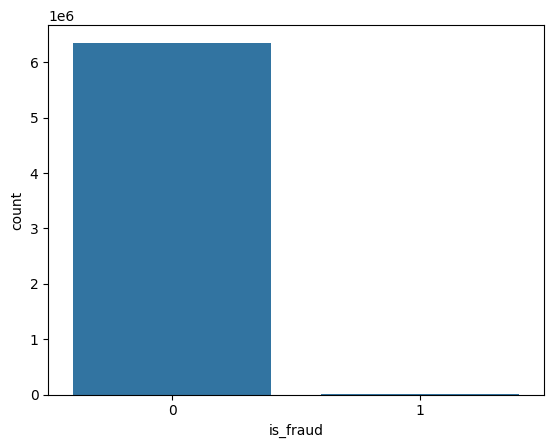

In [7]:
sns.countplot(x='is_fraud', data=fraud_df)

there are <br>
- 6354407 normal transactions
- 8213 fraud transactions

THe data is imbalance

check mean of amount of normal transaction and fraud transaction

In [8]:
fraud_df.groupby("is_fraud")[["amount"]].mean()

,amount
is_fraud,
0,1.781970e+05
1,1.467967e+06


fruad tranaction tends to have higher transfer amount

check correlation between amount and is_fraud

In [9]:
fraud_df[["amount","is_fraud"]].corr()

,amount,is_fraud
amount,1.000000,0.076688
is_fraud,0.076688,1.000000


check correlation between is_flagged_fraud and is_fraud

In [10]:
# correlation
fraud_df[["is_flagged_fraud","is_fraud"]].corr()

,is_flagged_fraud,is_fraud
is_flagged_fraud,1.000000,0.044109
is_fraud,0.044109,1.000000


In [11]:
cm = confusion_matrix(fraud_df["is_fraud"], fraud_df["is_flagged_fraud"])

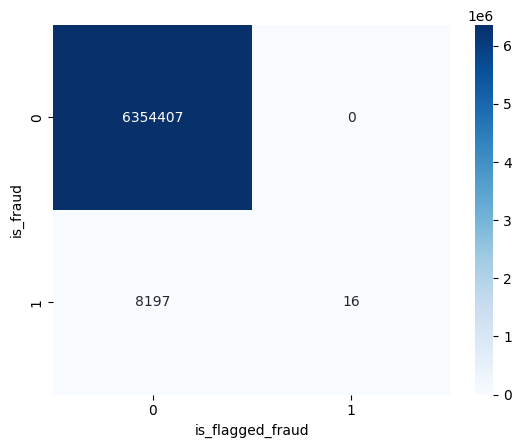

In [12]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('is_flagged_fraud')
plt.ylabel('is_fraud')
plt.show()

we found that the majority of is_flagged_fraud is 0. Hence, it is a major feature and can be remove

check correlation between amount, source balance, new source balance

In [13]:
fraud_df[["amount","src_bal","src_new_bal"]].corr()

,amount,src_bal,src_new_bal
amount,1.000000,-0.002762,-0.007861
src_bal,-0.002762,1.000000,0.998803
src_new_bal,-0.007861,0.998803,1.000000


src_bal and src_new_bal have high correlation with each other, it may not be suitable to use both of them simultaneously as a feature.

In [14]:
fraud_df[["amount","dst_bal","dst_new_bal"]].corr()

,amount,dst_bal,dst_new_bal
amount,1.000000,0.294137,0.459304
dst_bal,0.294137,1.000000,0.976569
dst_new_bal,0.459304,0.976569,1.000000


the pattern also apply to dst_bal and dst_new_bal

check number of fraud in each type of transaction

In [15]:
transaction_type_fruad_count = fraud_df.groupby(["is_fraud","transac_type"]).size().reset_index(name='count')
transaction_type_fruad_count

,is_fraud,transac_type,count
0,0,CASH_IN,1399284
1,0,CASH_OUT,2233384
2,0,DEBIT,41432
3,0,PAYMENT,2151495
4,0,TRANSFER,528812
5,1,CASH_OUT,4116
6,1,TRANSFER,4097


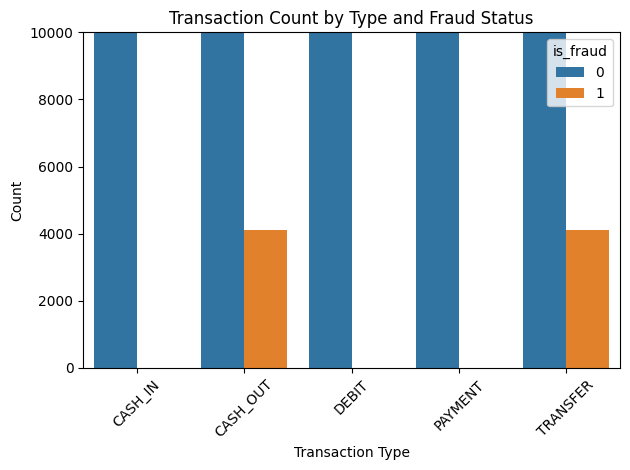

In [16]:
sns.barplot(data=transaction_type_fruad_count, x='transac_type', y='count', hue='is_fraud')
plt.title('Transaction Count by Type and Fraud Status')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.ylim(0,10000)
plt.tight_layout()
plt.show()

we only found fraud in CASH_OUT and TRANSFER

# Q2: training

## Feature selection

From EDA section we found that
- is_flagged_fraud is a major column 
- src_new_bal and dst_new_bal are highly correlated to src_bal and dst_bal respectively

So we remove them

we also remove src_acc, dst_acc , and time_ind as
- src_acc, dst_acc produced too many column after onehot encoding
- time_ind is use for train test split

In [17]:
fraud_df.columns

Index(['time_ind', 'transac_type', 'amount', 'src_acc', 'src_bal',
       'src_new_bal', 'dst_acc', 'dst_bal', 'dst_new_bal', 'is_fraud',
       'is_flagged_fraud'],
      dtype='object')

In [18]:
numerical_features = ['amount','src_bal','dst_bal',]
categorical_features = ['transac_type']

In [19]:
X = fraud_df[numerical_features + categorical_features]
y = fraud_df["is_fraud"]

## Train Test Split

For train test split I want to the test set to be the latest data in the simulation as when we inference the model the transaction time_ind will be greatFor the train-test split, I want the test set to consist of the most recent 15% of the data.

This reflects the real-world scenario where, during inference, the model will encounter transactions that occur after the training data timeline. Therefore, it makes sense to evaluate the model on the latest portion of the simulation data — simulating how well it would perform on unseen, future transactions.

In [20]:
# this was going to be used for hyperparameter tuning but the result is not as good as default hyperparameter so I will omit it.
# n_train = int(len(fraud_df)*0.70)
# n_val = int(len(fraud_df)*0.85)
# X_train = X.iloc[:n_train]
# y_train = y.iloc[:n_train]
# X_val = X.iloc[n_train:n_val]
# y_val = y.iloc[n_train:n_val]
# X_test = X.iloc[n_val:]
# y_test = y.iloc[n_val:]

In [21]:
n_train = int(len(fraud_df)*0.85)
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]
X_test = X.iloc[n_train:]
y_test = y.iloc[n_train:]

## Data preprocessing

for preprocessing I decide to use onehot encoding for category data and standard scaling for numerical data.<br>
After that I will apply SMOTE to increase fraud transaction in training dataset (imblearn pipeline only apply resample on training)

In [22]:
preprocessor = ColumnTransformer(
    [
        ("cat",OneHotEncoder(sparse_output=False,drop="first"),categorical_features),
        ("num",StandardScaler(),numerical_features)
    ]
)
smt = SMOTE(random_state=42)

## Hyperparameter tuning

In [23]:
# this was going to be used for hyperparameter tuning but the result is not as good as default hyperparameter so I will omit it.
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 300),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "use_label_encoder": False,
#         "eval_metric": "logloss",
#         "random_state": 42
#     }

#     xgb_clf = xgb.XGBClassifier(**params)

#     pipeline = Pipeline(steps=[
#         ("preprocessor", preprocessor),
#         ("smote", SMOTE(random_state=42)),
#         ("classifier", xgb_clf)
#     ])

#     pipeline.fit(X_train,y_train)

#     y_prob = pipeline.predict_proba(X_val)[:, 1]
#     precision, recall, thresholds = precision_recall_curve(y_val, y_prob)

#     f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)



#     return np.max(f1_scores)


In [24]:
# this was going to be used for hyperparameter tuning but the result is not as good as default hyperparameter so I will omit it.
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)

# print("Best trial:")
# print(study.best_trial.params)


## Train

In [25]:
# best_params = study.best_trial.params
# best_params.update({
#     "use_label_encoder": False,
#     "eval_metric": "logloss",
#     "random_state": 42
# })
# pipeline = Pipeline(steps=[("preprocessor",preprocessor),
#                             ("smt",smt),
#                             ('xgb', xgb.XGBClassifier(**best_params))
# ])

Connect preprocessor, resampler, and classifier together

In [26]:
pipeline = Pipeline(steps=[("preprocessor",preprocessor),
                            ("smt",smt),
                            ('xgb', xgb.XGBClassifier(random_state=42))
])

In [27]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['transac_type']),
                                                 ('num', StandardScaler(),
                                                  ['amount', 'src_bal',
                                                   'dst_bal'])])),
                ('smt', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_byt...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

For the evaluation we can't use roc curve as our test dataset is heavily imbalance. Instead of roc we use precision recall curve <br> to find the optimal threshold which can be done by finding the maximum f1 score

In [28]:
y_prob = pipeline.predict_proba(X_test)[:, 1]

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

In [30]:
print(best_threshold)

0.9880101


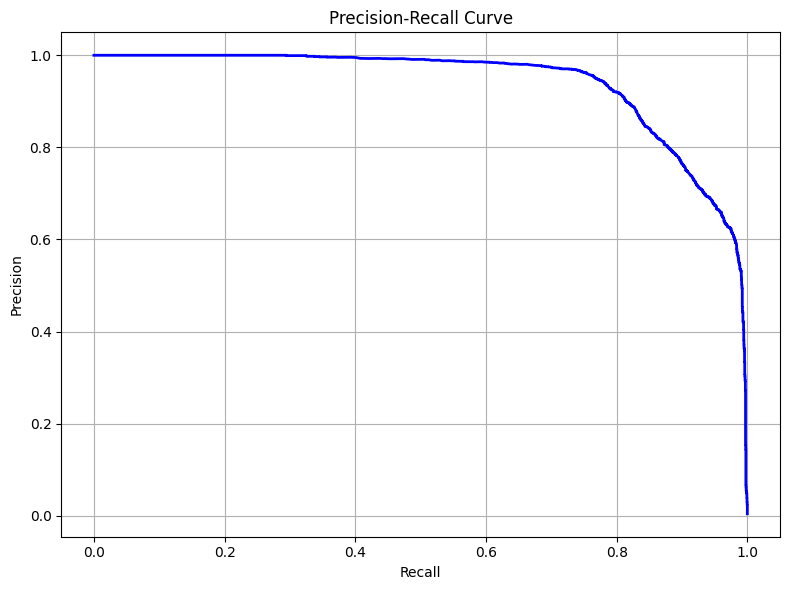

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
y_pred = (y_prob >= best_threshold).astype(int)
report = classification_report(y_test,y_pred,digits=4)

In [33]:
best_threshold

np.float32(0.9880101)

In [34]:
print(report)

              precision    recall  f1-score   support

           0     0.9992    0.9997    0.9994    950385
           1     0.9168    0.8056    0.8576      4008

    accuracy                         0.9989    954393
   macro avg     0.9580    0.9027    0.9285    954393
weighted avg     0.9988    0.9989    0.9988    954393



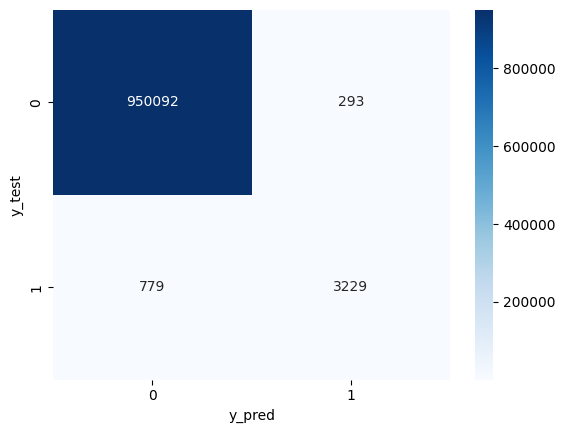

In [35]:
pred_confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pred_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

Currently the model seems to perform well on paper. However, it also show that there is significant number of false negative which in my opinion cause more damage to us than false positive. As false negative allow fraud transaction to occur in the system, decreasing our credibility in the process.<br><br>
Hence I want our model to have higher recall score for positive class

In [45]:
threshold = 0.97145
y_pred_tuned = (y_prob >= threshold).astype(int)
report_tuned = classification_report(y_test,y_pred_tuned,digits=4)

In [46]:
print(report_tuned)

              precision    recall  f1-score   support

           0     0.9996    0.9987    0.9992    950385
           1     0.7496    0.9069    0.8208      4008

    accuracy                         0.9983    954393
   macro avg     0.8746    0.9528    0.9100    954393
weighted avg     0.9986    0.9983    0.9984    954393



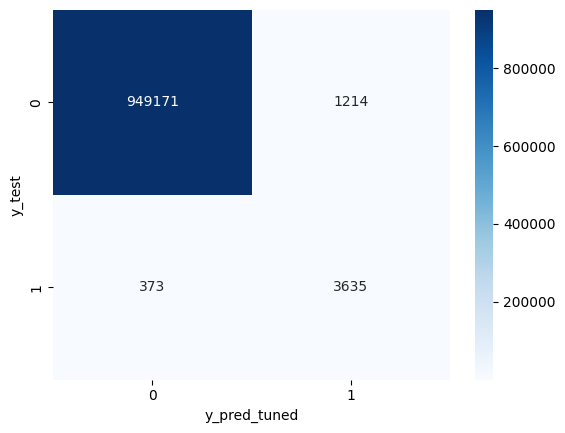

In [47]:
pred_confusion_matrix = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(pred_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('y_pred_tuned')
plt.ylabel('y_test')
plt.show()

In [39]:
import joblib
joblib.dump(pipeline, '../app/model/xgb_pipeline.pkl')

['../app/model/xgb_pipeline.pkl']